In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

np.random.seed(7)

# Data crunch

In [2]:
# load dataset
dataframe = pd.read_csv('data/final.csv', usecols=['logreturns'])
dataset = dataframe.values
dataset = dataset.astype('float32')

In [3]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [4]:
# split into train and test sets
train_size = int(len(dataset)-7)
test_size = len(dataset) - train_size
train =dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]

In [5]:
# convert an array of values into a dataset matrix with X=t, Y=t+1
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [6]:
# reshape input to be [sample, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])) # figure out what this does
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Fitting model

In [7]:
# train and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(25))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=32, verbose=2)

Epoch 1/5
143/143 - 2s - loss: 0.1793
Epoch 2/5
143/143 - 0s - loss: 0.0024
Epoch 3/5
143/143 - 0s - loss: 0.0023
Epoch 4/5
143/143 - 0s - loss: 0.0023
Epoch 5/5
143/143 - 0s - loss: 0.0023


In [8]:
# make predictions
forecast_normalized = model.predict(testX)
# inverting the normalization to original scale
forecast = scaler.inverse_transform(forecast_normalized)
testY = scaler.inverse_transform([testY])

# Evaluating

In [9]:
# Logreturns to price
test_df = pd.read_csv('data/final.csv', usecols=['logreturns', 'Close'])
train_full = test_df[:train_size]
test_full = test_df[train_size:len(test_df)-2].copy()

last_train = test_df['Close'].values[train_size - 1]
price_forecast = np.exp(np.cumsum(forecast[:,0]) + math.log(last_train))

test_full['forecast'] = price_forecast.tolist()
test_full['error'] = test_full['forecast'] - test_full['Close']
test_full.tail()

,Close,logreturns,forecast,error
4557,1235.13,-0.000631,1235.642212,0.512212
4558,1242.04,0.005579,1238.511353,-3.528647
4559,1249.10,0.005668,1241.432983,-7.667017
4560,1245.63,-0.002782,1240.076294,-5.553706
4561,1243.38,-0.001808,1239.213257,-4.166743


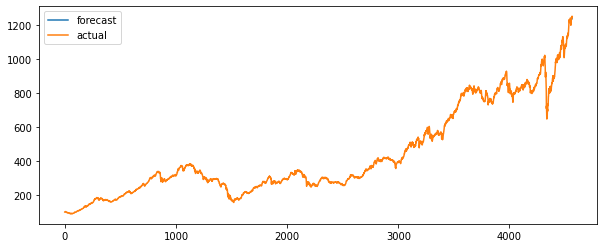

In [10]:
# Plotting predictions
plt.figure(figsize=(10, 4))
plt.plot(test_full['forecast'], label="forecast")
plt.plot(test_df['Close'], label="actual")
plt.legend()

In [11]:
# RMSE and MAE
def evaluate(n_periods):
    df = test_full[:n_periods]
    mape = np.mean(np.abs((df['error']) / df['Close'])) * 100
    rmse = math.sqrt(np.mean(pow(df['error'], 2)))
    print(f"RMSE: {round(rmse, 3)}, MAPE: {round(mape, 3)}%")

evaluate(1)
evaluate(3)
evaluate(5)

RMSE: 0.512, MAPE: 0.041%
RMSE: 4.882, MAPE: 0.313%
RMSE: 4.893, MAPE: 0.344%
